# Can a deep learning model detect phishing emails?

### Atishay Dikshit

# Introduction

#### Phishing emails remain amongst the most widespread cybersecurity threats. These emails often get past standard filtering systems and may carry sensitive information at risk. This project is about methodologies for phishing detection using an advanced AI-powered model, incorporating both traditional techniques of machine learning and deep learning through LSTM networks.

#### The model will be using NLP to analyze the content of the emails and pick up subtle patterns that are typical in phishing attacks. This project takes a few different tacks in classifying emails as either "safe" or "phishing," using TF-IDF and Count Vectorizer for feature extraction, and Logistic Regression, Random Forests, and neural network classifiers. LSTM will help us to understand the relations of words, which may catch intricate patterns in the text of an email that other models could miss.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, learning_curve
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
import re
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

2024-11-13 01:44:43.783339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
df = pd.read_csv("phishing.csv")
df_sample = df.sample(n=5, random_state=42)
df_sample

,Unnamed: 0,Email Text,Email Type
14469,14470,"Once upon a time, Harri wrote :> Title page ha...",Safe Email
3014,3014,new books : generative studies we would like t...,Safe Email
16941,16942,new book : japanese linguistics japanese lingu...,Safe Email
14344,14345,renewal notice for your domain name ( s ) dear...,Safe Email
8097,8098,hot stock tip your broker won ' t share now th...,Phishing Email


# Phase 1: Data cleaning

#### From the initial observation of the email data, it is clear that effective data cleaning is critical in ensuring effective vectorization to ultimately get accurate classification from our machine learning model.

#### Machine learning algorithms require clean, well-prepared data to reveal meaningful patterns and make accurate predictions. Email data can be noisy, containing lots of irrelevant information, inconsistencies, and various artifacts that could interfere with vectorization. By cleaning the data, we improve the quality of features to be extracted, helping the model focus on the important parts of each email.

#### Emails are often filled with HTML tags, special characters, and formatting elements, none of which help in understanding the text content. Removing these elements simplifies the data, allowing the vectorization process to focus on meaningful words only. Additionally, converting all text to lowercase ensures that words in different cases are treated as the same (e.g., "Urgent" and "urgent" should be recognized as the same word). This normalization step helps make the dataset more consistent.


## 1.1 | Removing null values

In [5]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [6]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

## 1.2 | Removing punctuation, hyperlinks & leading/trailing whitespace

In [7]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
     # remove any hyperlinks [proceeded by http]
    text = re.sub(r'http\S+', ' ', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text

df["Email Text"] = df["Email Text"].apply(clean_text)

In [8]:
df.isnull().sum()

Email Text    0
Email Type    0
dtype: int64

## 1.3 | Binary Encoding

#### This will turn the categorical labels "phishing" and "safe" into numeric values that machine learning models are capable of dealing with, preparing the data for such algorithms as SGDClassifier to directly interface with. In a binary classification problem, such as phishing detection, integer encoding simplifies the task because each class receives a unique integer, say 0 and 1, with which model training and evaluation become pretty straightforward.

#### *Afterthought: this kind of encoding saves memory by making data storage in the case of integer labels more efficient compared to strings. By ensuring that labels are kept the same, integer encoding further helps in interpreting model outputs.*

In [9]:
le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])

# Phase 2: Text Vectorization

## Why Text Vectorization?
#### The Machine Learning model requires numerical data; it does not process raw text. The text must be converted into numbers such that the model finds some type of pattern in the data for analysis and classification.
## TF-IDF (Term Frequency-Inverse Document Frequency)
#### This method gives more importance to each word regarding its frequency across all the emails. Words appearing in most of the emails bear less weight (e.g., "the" or "and"), although words that show up less frequently (like "compromise" in phishing emails) bear a weight that is higher. This is so that significance may be outlaid to those words which matter most toward classification.

## Vectorization in context
#### These techniques are applied to the emails, and each one is represented as a vector—a list of numbers. These vectors are then used by machine learning models to learn patterns and make predictions. In other words, the conversion of our text data into a meaningful format is to prepare text for analysis to assist our model in performing the actual classification of e-mails based on patterns in the language.
## Why TF-IDF over other techniques?

### <u>Advantages:</u>
 > Efficiency: Count Vectorizer is computationally efficient and well-suited for straightforward keyword frequency approaches, making it ideal for datasets with a predefined vocabulary.

> Interpretability:
Each feature is a direct word count, making it easy to interpret which words have the most influence on classification.

### <u>Limitations:</u>

> Count Vectorizer does not consider the importance of words across documents (emails, in this case). Common words like "dear" or "please" will likely have similar weights in both phishing and legitimate emails, potentially diluting meaningful signals.
</p>

In [10]:
# initialize a new tfid vectorizer called tf, it will remove common words like
# "and" and "the" in the english idiom, and limit max num of unique words to 10000
tf = TfidfVectorizer(stop_words="english",max_features=10000)

feature_x = tf.fit_transform(df["Email Text"]).toarray()

In [11]:
y_tf = np.array(df['Email Type'])

In [12]:
# we will opt for a standard 80-20 split when it comes to training and testing data sizes
x_train,x_test,y_train,y_test = train_test_split(feature_x,y_tf,train_size=0.8,random_state=0)

# Phase 3: Algorithms

## 3.1 | SGD Classifier

### Methodology

#### We will be using mini-batch gradient descent, which updates the model weights in an incremental manner. It is memory-efficient since only partial data is loaded and processed at any given time. Shuffling at the start of each epoch ensures that each mini-batch is diverse, allowing the model to learn effectively.

In [13]:
sgd = SGDClassifier(loss='log_loss')

n_epochs = 10       
batch_size = 64     # mini batch size
train_losses = []  
test_losses = []    
train_accuracies = []  
test_accuracies = []   

for epoch in range(n_epochs):
    indices = np.random.permutation(len(x_train))
    x_train_shuffled = x_train[indices]
    y_train_shuffled = np.array(y_train)[indices]
    
    for i in range(0, len(x_train), batch_size):
        batch_x = x_train_shuffled[i:i + batch_size]
        batch_y = y_train_shuffled[i:i + batch_size]
        sgd.partial_fit(batch_x, batch_y, classes=[0, 1])
    

    train_pred_prob = sgd.predict_proba(x_train)
    train_loss = log_loss(y_train, train_pred_prob)
    train_losses.append(train_loss)
    train_pred = sgd.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_accuracy)
    

    test_pred_prob = sgd.predict_proba(x_test)
    test_loss = log_loss(y_test, test_pred_prob)
    test_losses.append(test_loss)
    test_pred = sgd.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_accuracy)


print(f"SGD Classifier Accuracy: {accuracy_score(y_test, test_pred) * 100:.2f}%")
print(f"SGD Classifier F1 Score: {f1_score(y_test, test_pred) * 100:.2f}%")

SGD Classifier Accuracy: 98.00%
SGD Classifier F1 Score: 98.39%


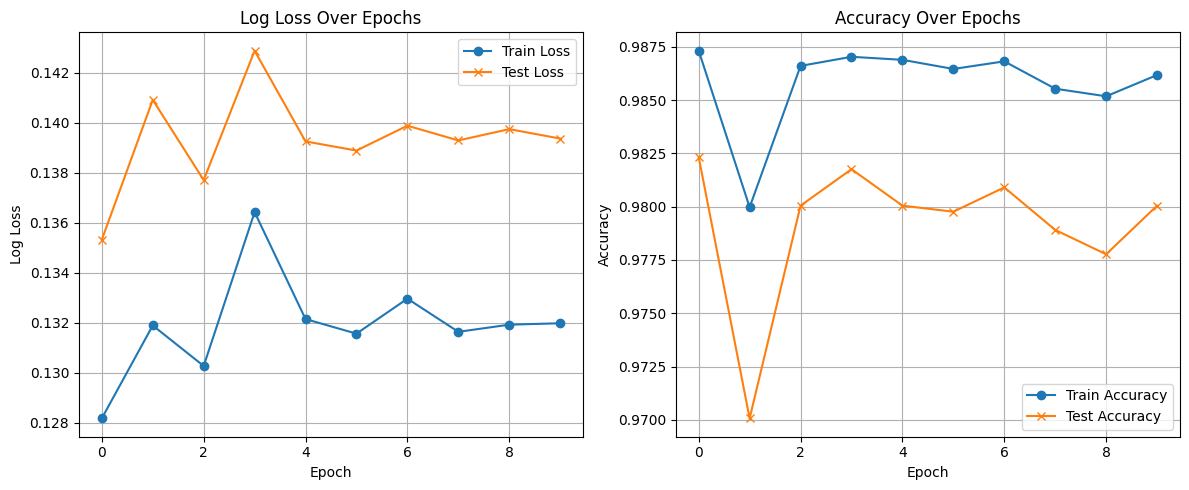

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_losses, marker='o', label="Train Loss")
plt.plot(range(n_epochs), test_losses, marker='x', label="Test Loss")
plt.title("Log Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_accuracies, marker='o', label="Train Accuracy")
plt.plot(range(n_epochs), test_accuracies, marker='x', label="Test Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Analysis

#### The left graph shows the trend of the training and test log loss. A potential overfitting problem can be seen since the stabilization of the training loss has only minor fluctuations, indicating that the model is learning the training data well; however, it cannot generalize to unseen data due to the consistently higher test loss. 

#### This is a common indicator of overfitting, as the model fits well on the training distribution but captures patterns that do not generalize. Further supporting this idea, the graph on the right represents the training and test accuracy by epoch. Training accuracy has stabilized near 98.5%, while test accuracy remains consistently lower. This accuracy gap reinforces the notion that the model is overfitting to the training data, thereby reducing its predictive power on the test set.

<h2>3.2 | Logistic Regression</h2>

### Background

#### Logistic regression is used for binary classification, helping determine the likelihood that an input falls into one of two categories. It works by applying a logistic (sigmoid) function to a weighted sum of input features. This model often uses gradient descent to optimize and find the best values for these weights. 

#### Logistic regression is based on the assumption of a linear relationship between the independent variables and the log-odds of the outcome, which makes it well-suited for cases where the two classes are linearly separable or close to it. 

<h3>Methodology</h3>

#### In this dataset, which classifies emails as either "Safe Email" or "Phishing Email," logistic regression serves as a reliable baseline model. Its simplicity offers an interpretable comparison against more complex models, like the SGDClassifier with mini-batch training. Logistic regression’s training involves fitting the entire dataset at once, providing a consistent reference for evaluating incremental learning methods like SGD.

In [15]:
lgreg = LogisticRegression()
lgreg.fit(x_train,y_train)

pred_lgreg = lgreg.predict(x_test)
print("")
print(f"Logistic Regression Accuracy:{accuracy_score(y_test,pred_lgreg)*100:.2f} %")
print(f"Logistic Regression F1 Score: {f1_score(y_test,pred_lgreg)*100:.2f} %")


Logistic Regression Accuracy:98.06 %
Logistic Regression F1 Score: 98.43 %


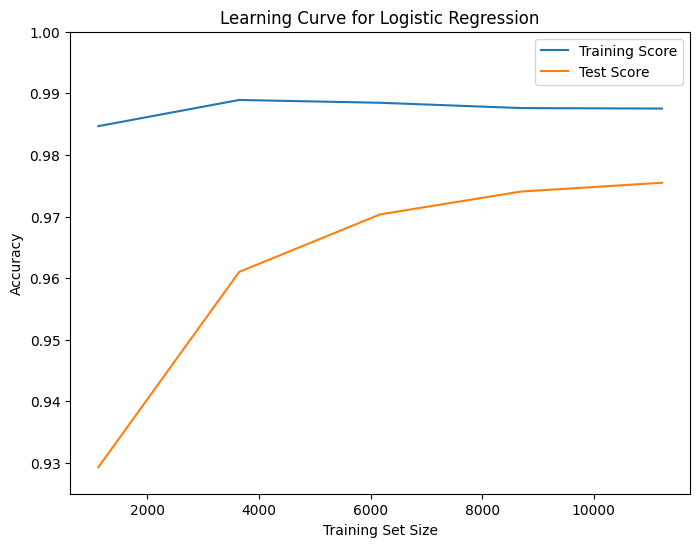

In [16]:
train_sizes, train_scores, test_scores = learning_curve(lgreg, x_train, y_train, cv=5)

# learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.ylim(0.925, 1)
plt.title('Learning Curve for Logistic Regression')
plt.legend()
plt.show()

### Analysis

#### The learning curve above demonstrates the training and validation accuracy of the logistic regression model progress as the training set size increases. Initially, the training accuracy is high, stabilizing around 99%, which suggests the model is fitting the training data well, with only minor overfitting. 

#### In contrast, the validation accuracy starts lower but gradually improves as the training set expands, eventually leveling off just below the training accuracy at above 97%. This pattern indicates that logistic regression can generalize effectively to new, unseen data, with only a minimal performance gap between training and validation sets, especially as more data is introduced. 

#### The narrowing gap in accuracy between training and validation at larger sample sizes suggests that the model continues to benefit from additional data, which enhances its ability to generalize.

<h2>3.3 | Decision Tree</h2>

### Background

#### The decision tree classifier is a nonlinear and hierarchical model. It works by recursively splitting sets of data into subsets based on feature values, with the aim of constructing a tree structure used for classifying instances. Every split in the tree is chosen so as to maximize information gain or minimize impurity for the target class, effectively creating decision boundaries that are often nonlinear and capture complex relationships within the data.

### Training

In [17]:
dtr = DecisionTreeClassifier()
dtr.fit(x_train,y_train)
pred_dtr = dtr.predict(x_test)

print(f"Decision Tree Accuracy:{accuracy_score(y_test,pred_dtr)*100:.2f} %")
print(f"Decision Tree F1 Score: {f1_score(y_test,pred_dtr)*100:.2f} %")

Decision Tree Accuracy:93.76 %
Decision Tree F1 Score: 94.89 %


### Decision Tree Visualization

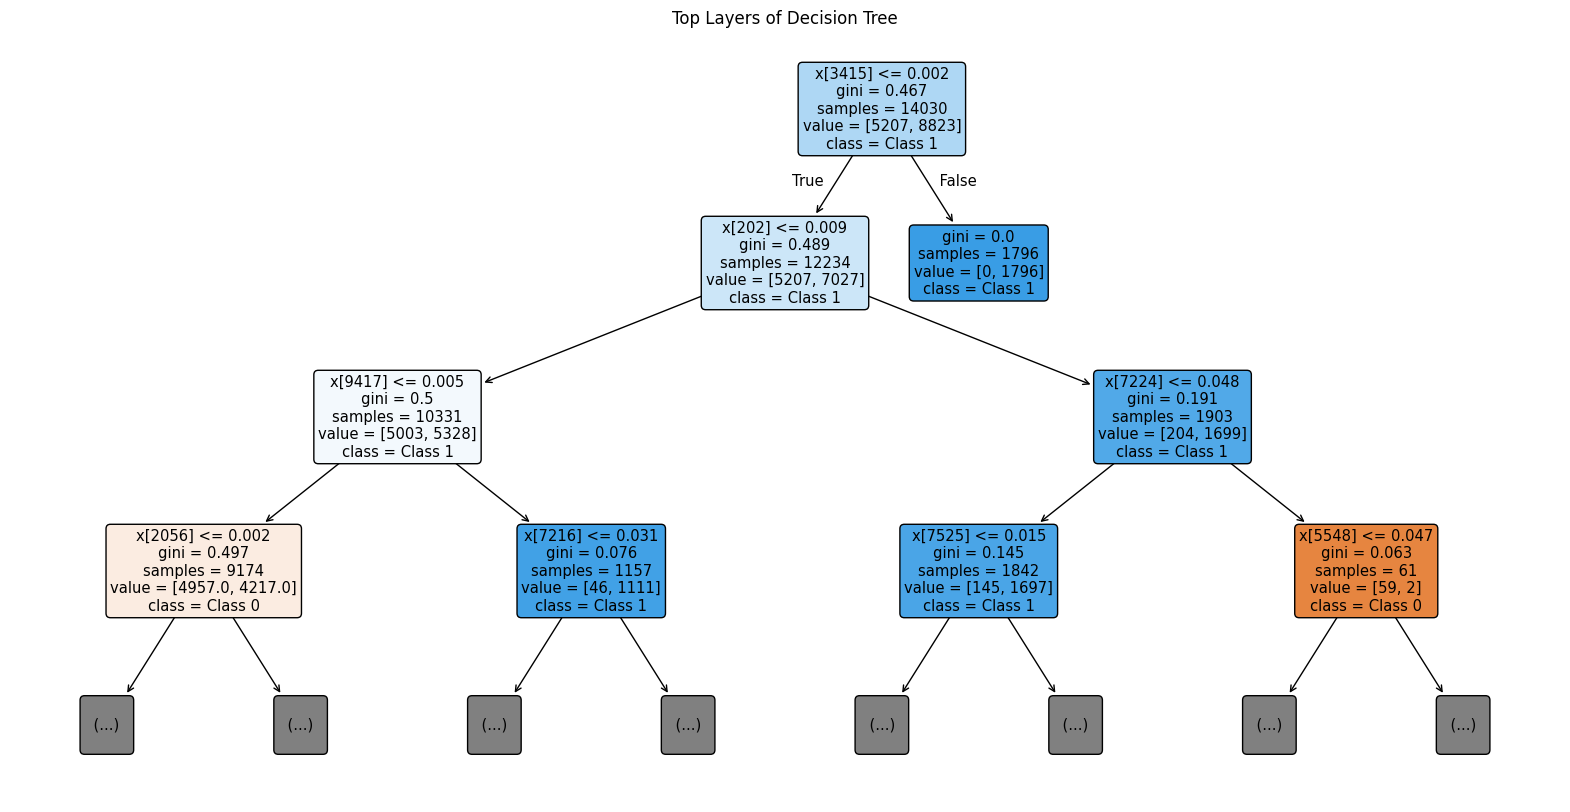

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(dtr, 
          max_depth=3,
          filled=True, 
          class_names=['Class 0', 'Class 1'], 
          rounded=True)
plt.title("Top Layers of Decision Tree")
plt.show()

### Gini Impurity
#### Each node shows the Gini impurity, a measure of how mixed the classes are within that node. Lower Gini values indicate purer nodes, meaning samples in those nodes are more homogeneously classified into a single class. For example, the node with x[7216] <= 0.031 has a low Gini value of 0.076, suggesting that it predominantly contains samples of "Class 1".

### Decision Boundaries
#### The top layers of the tree show broader decision boundaries, which make high-level splits in the data. As the tree progresses to deeper layers, the splits become more specific, capturing finer details that may lead to overfitting if the tree becomes too deep. The presence of nodes with a Gini of 0.0 (e.g., x[3415] <= 0.002 on the right) suggests that the model perfectly separates samples within those nodes.

<h2>3.4 | Random Forests</h2>

### Background

#### Random Forests help classify emails as "Phishing" or "Safe" by leveraging TF-IDF to transform email content into numerical features. Important indicators, words or phrases commonly used in phishing emails are taken into account. By combining multiple decision trees, each trained on random subsets of the data and features, Random Forests improve generalization and reduce overfitting, effectively distinguishing phishing emails from legitimate ones even within noisy, high-dimensional text data.

### Training

In [19]:
rnf = RandomForestClassifier()
rnf.fit(x_train,y_train)
pred_rnf = rnf.predict(x_test)
print(f"Random Forest Accuracy::{accuracy_score(y_test,pred_rnf)*100:.2f} %")
print(f"Random Forest F1 Score: {f1_score(y_test,pred_rnf)*100:.2f} %")

Random Forest Accuracy::97.89 %
Random Forest F1 Score: 98.28 %


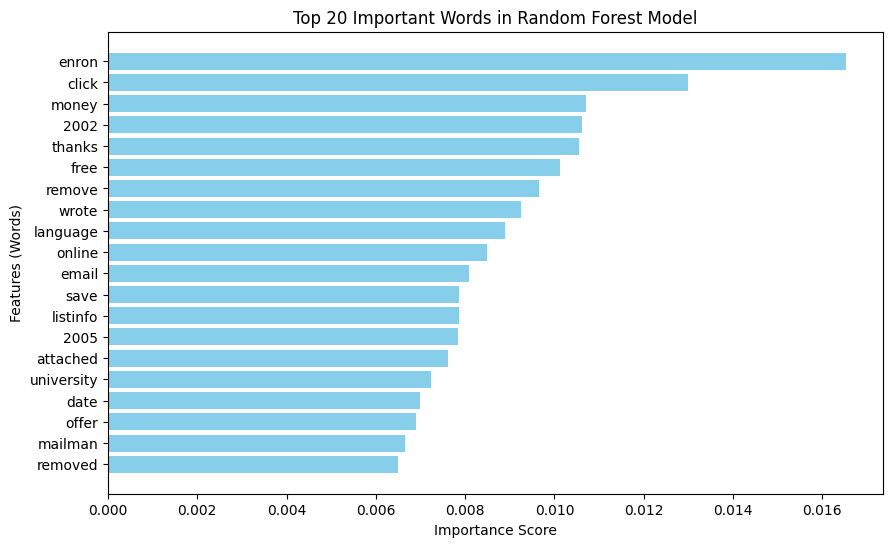

In [20]:
feature_importances = rnf.feature_importances_
feature_names = tf.get_feature_names_out()

importance_df = pd.DataFrame({'Feature': feature_names,'Importance': feature_importances})
top_n = 20
top_features = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features (Words)')
plt.title(f'Top {top_n} Important Words in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

### Analysis

#### Words like "click," "remove," "free," and "money" align well with known phishing strategies, where the intent is often to prompt immediate action or exploit financial interests.

#### The prominence of "Enron" suggests the model may be partially influenced by dataset-specific characteristics rather than general phishing behaviors, which could impact its performance on emails unrelated to the Enron context.


# Phase 4 | Long Short-Term Memory (LSTM) Architecture

## Background

#### LSTM are a category of recurrent neural network designed to capture dependencies in sequential data by retaining relevant information over time steps. LSTMs use memory cells with gates that control what information to keep or forget, making them especially effective for tasks where the order and context of data points are important, such as text processing. In the context of phishing classification, LSTMs are well-suited for distinguishing "Phishing" from "Safe" emails because they can capture patterns in word sequences, detect phrases commonly used in phishing attacks, and differentiate the context in which specific words appear. 

## Methodology

#### The email texts are first preprocessed and tokenized, converting each word into embeddings representing semantic relationships. These embeddings are then passed through one or more LSTM layers, where the model learns sequential patterns and retains contextual information relevant to the classification task. The final LSTM outputs are fed into fully connected layers and a sigmoid output layer, predicting the probability of an email being phishing. The model's performance is evaluated using metrics like accuracy and F1 score to ensure effective detection of phishing patterns in the dataset.

In [10]:
tk = Tokenizer()
tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=150)
x = np.array(vector)
y = np.array(df["Email Type"])
x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

## Deep Dive into our parameters

#### The LSTM layer with 110 units processes the sequential nature of text, allowing the model to retain context over word sequences, which is critical for understanding the structure and intent in emails. 

#### The Dense layer with a sigmoid activation outputs a single probability, ideal for binary classification, as it maps values between 0 and 1. The Adam optimizer combines the benefits of both AdaGrad and RMSProp, adapting the learning rate individually for each parameter based on estimates of first and second moments of gradients. Adam is particularly effective for sparse data and sequences, making it a popular choice for NLP tasks like this; alternative optimizers like SGD may converge slower, while RMSProp may lack some adaptive flexibility.

In [11]:
lst = Sequential()
lst.add(Embedding(input_dim=len(tk.word_index)+1, output_dim=75))
lst.add(LSTM(units=110))
lst.add(Dropout(0.5))
lst.add(Dense(1, activation='sigmoid'))
lst.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [12]:
track = lst.fit(x_train, y_train, epochs=5, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 105s 118ms/step - accuracy: 0.7192 - loss: 0.5514 - val_accuracy: 0.9239 - val_loss: 0.2342
Epoch 2/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 104s 119ms/step - accuracy: 0.9030 - loss: 0.2589 - val_accuracy: 0.9518 - val_loss: 0.1680
Epoch 3/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 105s 120ms/step - accuracy: 0.9697 - loss: 0.1128 - val_accuracy: 0.9031 - val_loss: 0.2154
Epoch 4/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 110s 125ms/step - accuracy: 0.9717 - loss: 0.0922 - val_accuracy: 0.9723 - val_loss: 0.1137
Epoch 5/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 107s 122ms/step - accuracy: 0.9894 - loss: 0.0471 - val_accuracy: 0.9701 - val_loss: 0.1097


In [34]:
results = lst.evaluate(x_test, y_test)
loss = results[0]
accuracy = results[1]

print(f"Model Loss: {loss}")
print(f"Model Accuracy: {accuracy*100}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9825 - loss: 0.0761
Model Loss: 0.07902191579341888
Model Accuracy: 98.204106092453


Text(0, 0.5, 'Loss')

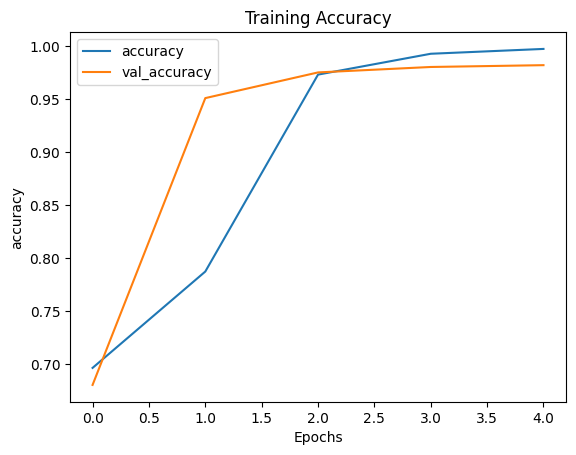

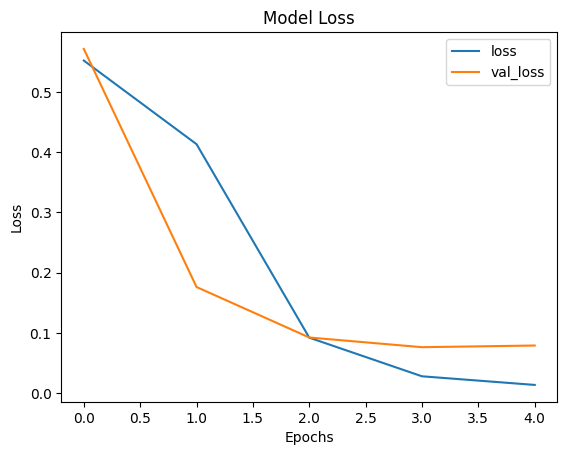

In [35]:
pd.DataFrame(track.history)

pd.DataFrame(track.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(track.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Analysis and Conclusion

#### The LSTM model shows a strong upward trend in accuracy and a consistent reduction in loss over the five training epochs, indicating effective learning. Training accuracy quickly improves from around 70% in the second epoch to 99% by the fifth, with validation accuracy following closely, reaching 97%. 

#### The slight gap between training and validation metrics suggests good generalization without significant overfitting. The model’s final performance on the test set shows an accuracy of 98.20% and a low loss of 0.079, which confirms its effectiveness in distinguishing between phishing and safe emails.

#### We can conclue that this LSTM model effectively captures sequential patterns in the email text data, achieving high accuracy and low loss across both training and validation sets. This strong performance implies that the model generalizes well to unseen data, making it a viable solution for email classification tasks, specifically for detecting phishing content.

In [13]:
import pickle

# Save tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tk, f)